# Full annotations dataframe creation

The goal of this notebook is to create and save a dataframe with the key informations of nodules. In particular the dataframe will contain the SeriesInstanceUid, the world coordinates, the diameter, the malignancy level and the class of each nodules. 

The firs three values are taken from the annotation file of LUNA16 (available here: https://zenodo.org/record/3723295#.Y86jInbMLe9). Instead the malignancy level value isn't availale in the LUNA16 annotations file so this information is taken from the annotations of LIDC-IDRI dataset (in particular the 'LIDC-XML-only' folder, the dataset and annoations files are available here: https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=1966254). 

The nodule class is computed looking at the malignancy level, in particular if the level is <= 3 the class is benign (1) and if the level is >= 4 the class is malignant (0).

In [1]:
import os

import pandas as pd

from bs4 import BeautifulSoup

In [2]:
# extraction of id and malignancy level from each xml file
folder_path = 'LIDC-XML-only'
folders = os.listdir(folder_path)

id_list = []
malignancy_list = []

for f in folders:
    print(f'Processing folder "{f}"')
    dir_list = os.listdir(folder_path + '/' + f)
   
    for xml_file in dir_list:
        xml_file_path = folder_path + '/' + f + '/' + xml_file
        
        with open(xml_file_path, 'r') as xml_f:
            data = xml_f.read()

            Bs_data = BeautifulSoup(data, 'html.parser')

            try:
                malignancy = int(Bs_data.find('malignancy').get_text())
            except:
                malignancy = 0 # if malignancy = 0: missing value
                
            uid = Bs_data.find('seriesinstanceuid').get_text()
            
            id_list.append(uid)
            malignancy_list.append(malignancy)
            

Processing folder "157"
Processing folder "185"
Processing folder "186"
Processing folder "187"
Processing folder "188"
Processing folder "189"


In [5]:
# malignancy dataframe creation
data_dict = {
    'seriesuid': id_list,
    'malignancy_Level': malignancy_list
}

malignancy_df = pd.DataFrame(data_dict)
print(f'Shape with duplicates: {malignancy_df.shape}')
malignancy_df = malignancy_df.drop_duplicates()
print(f'Shape without duplicates: {malignancy_df.shape}')

malignancy_df.head()

Shape with duplicates: (1318, 2)
Shape without duplicates: (1294, 2)


,seriesuid,malignancy_Level
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102...,3
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.131939324905...,5
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.213233719488...,3
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.340202188094...,4
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.311102747717...,2


In [7]:
# read annotations.csv file
annotations_df = pd.read_csv('annotations.csv')
annotations_df.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [8]:
# join of malignancy_df to annoations_df
df = annotations_df.join(malignancy_df.set_index('seriesuid'), on='seriesuid')
print(df.shape)
df.head()

(1186, 6)


,seriesuid,coordX,coordY,coordZ,diameter_mm,malignancy_Level
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,4
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708,4
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,3
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,5
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,5


1    148
2    315
3    340
4    220
5    163
Name: malignancy_Level, dtype: int64


<AxesSubplot: >

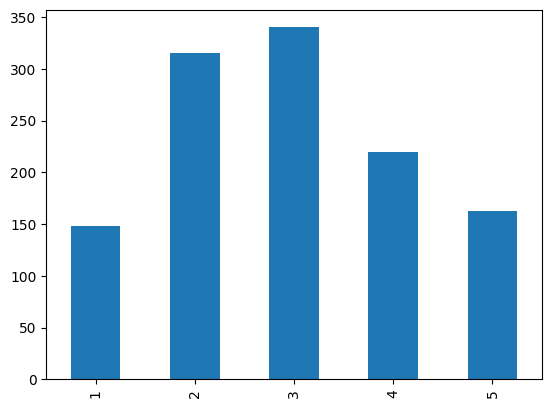

In [9]:
# check if there are row with malignancy_level = 0
values = df['malignancy_Level'].value_counts().sort_index()
print(values)
values.plot(kind='bar')

In [10]:
# add one column with the class: {malignant: 0, benign: 1} to df
class_list = []
for idx in range(len(df)):
    level = df['malignancy_Level'][idx]
    if level >= 4: # nodule is malignant
        class_list.append(0)
    else: 
        class_list.append(1)

df['class'] = class_list
df.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,malignancy_Level,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,4,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708,4,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,3,1
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,5,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,5,0


0    383
1    803
Name: class, dtype: int64


<AxesSubplot: >

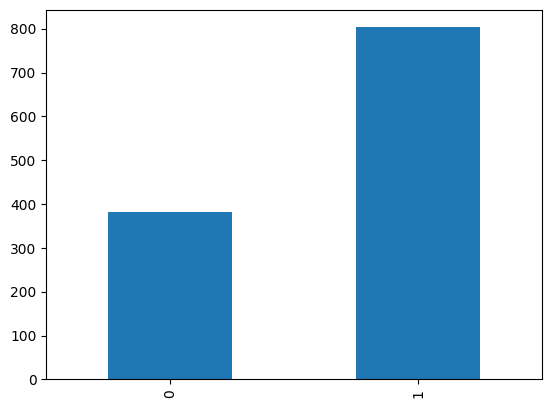

In [11]:
# check class values distribution
class_values = df['class'].value_counts().sort_index()
print(class_values)
class_values.plot(kind='bar')

In [12]:
# save dataframe
df.to_csv('full_annotations.csv')
print('Done')

Done
